# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix

In [177]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.002 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [130]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])


# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.


# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

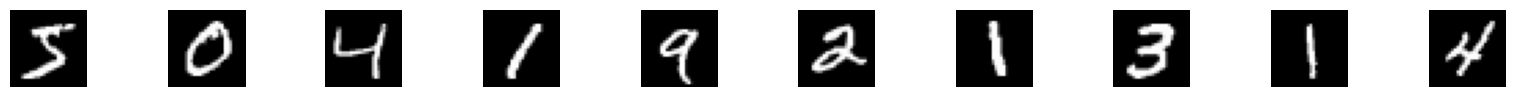

In [131]:
fig, axes = plt.subplots(1, 10, figsize=(20,1))

for i in range(10):
  axes[i].imshow(x_train[i].reshape(28,28), cmap='gray')
  axes[i].axis('off')

In [179]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None, activation='sigmoid'):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name='weight')
        self.b = tf.Variable(tf.zeros([out_features]), name='bias')
        self.activation = activation

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        if self.activation == "relu":
            y = tf.nn.relu(y)
        elif self.activation == "softmax":
            y = tf.nn.softmax(y)
        elif self.activation == "sigmoid":
            y = tf.nn.sigmoid(y)

        return y


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.dense_layer1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)


    # Второй слой, состоящий из 256 нейронов
    self.dense_layer2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)


    # Выходной слой
    self.out_dense_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes, activation='softmax')

  def __call__(self, x):
    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
    # принадлежности входного объекта к одному из 10 классов

    x = self.dense_layer1(x)
    x = self.dense_layer2(x)
    x = self.out_dense_layer(x)

    return x

In [180]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)


In [181]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")
optimizer = tf.optimizers.SGD(learning_rate)
# Функция обучения нейросети
@tf.function
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    nn_variables = nn.variables


    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, neural_net.trainable_variables)

    # Модифицируем параметры
    optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))

In [182]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1): # Место для вашего кода:
    # Обновляем веса нейронной сети
    # Место для вашего кода
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)

        # Место для вашего кода
        loss = cross_entropy(pred, batch_y)
        accur = accuracy(pred, batch_y)


        loss_history.append(loss)
        accuracy_history.append(accur)

        print(f"Step {step}, Loss: {loss:.4f}, Accuracy: {accur:.4f}")

Step 100, Loss: 249.1050, Accuracy: 0.7344
Step 200, Loss: 148.3652, Accuracy: 0.8477
Step 300, Loss: 95.4248, Accuracy: 0.8906
Step 400, Loss: 115.6783, Accuracy: 0.8555
Step 500, Loss: 114.7487, Accuracy: 0.8633
Step 600, Loss: 124.5223, Accuracy: 0.8555
Step 700, Loss: 59.6047, Accuracy: 0.9336
Step 800, Loss: 66.7005, Accuracy: 0.9141
Step 900, Loss: 92.1376, Accuracy: 0.8984
Step 1000, Loss: 85.4981, Accuracy: 0.8945
Step 1100, Loss: 69.3524, Accuracy: 0.9219
Step 1200, Loss: 71.9735, Accuracy: 0.9102
Step 1300, Loss: 54.8852, Accuracy: 0.9219
Step 1400, Loss: 60.4422, Accuracy: 0.9453
Step 1500, Loss: 60.0402, Accuracy: 0.9297
Step 1600, Loss: 48.6145, Accuracy: 0.9258
Step 1700, Loss: 55.3053, Accuracy: 0.9336
Step 1800, Loss: 38.9808, Accuracy: 0.9453
Step 1900, Loss: 53.5988, Accuracy: 0.9453
Step 2000, Loss: 45.7450, Accuracy: 0.9414
Step 2100, Loss: 41.8645, Accuracy: 0.9531
Step 2200, Loss: 73.4525, Accuracy: 0.9414
Step 2300, Loss: 59.2878, Accuracy: 0.9258
Step 2400, Loss

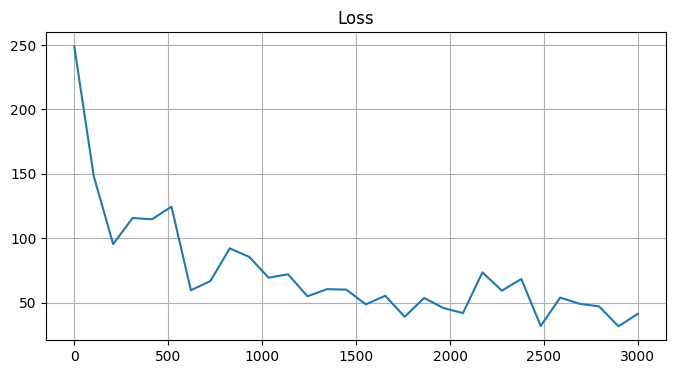

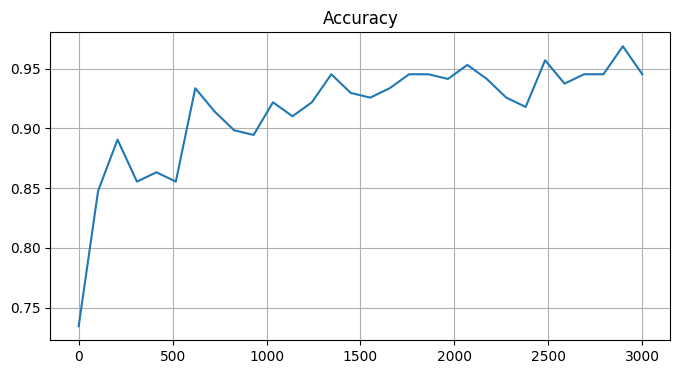

In [183]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, 3000, 30), loss_history)
plt.title("Loss")
plt.grid()
plt.show()
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, 3000, 30), accuracy_history)
plt.title("Accuracy")
plt.grid()
plt.show()

In [184]:
pred_test = neural_net(x_test)
test_acc = accuracy(pred_test, y_test)
print(f"Accuracy of model with test data: Accuracy = {test_acc.numpy():.4f}")

Accuracy of model with test data: Accuracy = 0.9240


In [185]:
predictions = neural_net(x_train)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

precision = precision_score(y_train, predicted_labels, average='macro')
recall = recall_score(y_train, predicted_labels, average='macro')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Precision: 0.9459
Recall: 0.9455


In [186]:
# Calculate precision and recall for each class
precision_per_class = precision_score(y_train, predicted_labels, average=None)
recall_per_class = recall_score(y_train, predicted_labels, average=None)
total = 0

for class_idx, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
  total += precision
  print(f"Class {class_idx}:")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")



Class 0:
Precision: 0.9747
Recall: 0.9743
Class 1:
Precision: 0.9762
Recall: 0.9855
Class 2:
Precision: 0.9477
Recall: 0.9369
Class 3:
Precision: 0.9597
Recall: 0.8968
Class 4:
Precision: 0.9660
Recall: 0.9254
Class 5:
Precision: 0.8849
Recall: 0.9585
Class 6:
Precision: 0.9746
Recall: 0.9615
Class 7:
Precision: 0.9618
Recall: 0.9513
Class 8:
Precision: 0.9252
Recall: 0.9127
Class 9:
Precision: 0.8879
Recall: 0.9521


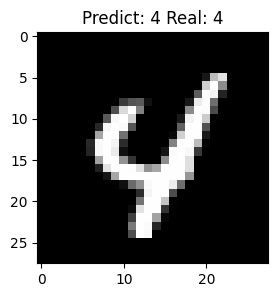

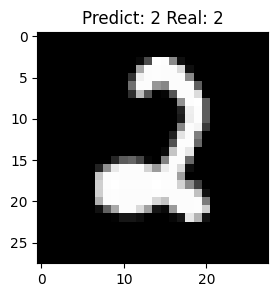

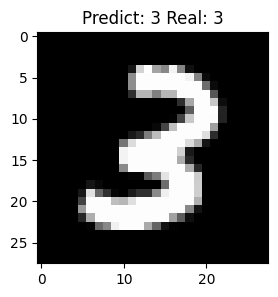

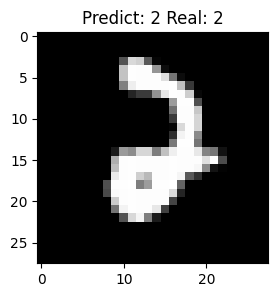

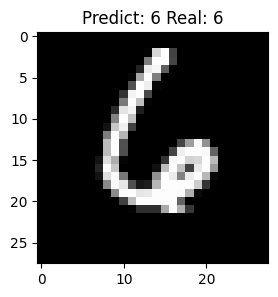

In [187]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

rand_idx = np.random.choice(len(x_test), 10, replace=False)
x_test_10 = x_test[rand_idx]
y_test_10 = y_test[rand_idx]
pred_10 = neural_net(x_test_10).numpy()
acc_10 = accuracy(pred_10, y_test_10)
pred_10 = pred_10.argmax(axis=1)

for i in range(5):
    plt.figure(figsize=(3, 3))
    plt.imshow(x_test_10[i].reshape(28, 28), cmap="gray")
    plt.title(f"Predict: {pred_10[i]} Real: {y_test_10[i]}")
    plt.show

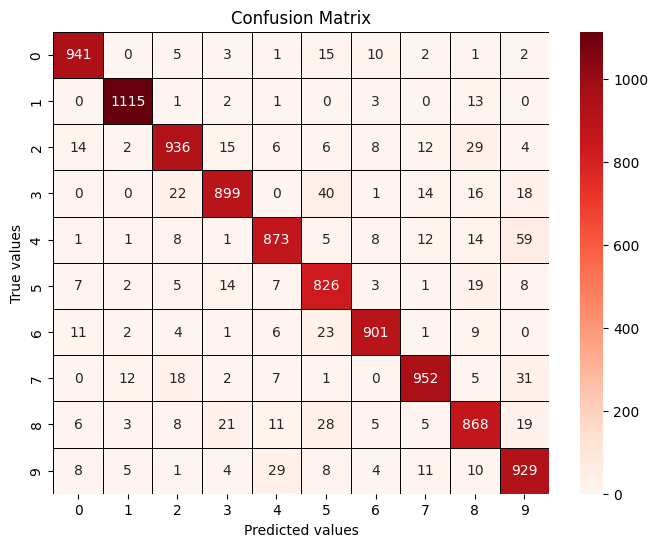

In [195]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = neural_net(x_test)
predicted_labels = tf.argmax(y_pred, axis=1).numpy()

cm = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=range(10), yticklabels=range(10), linewidths=0.5, linecolor="black")
plt.title("Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.show()

Висновок: як ми бачимо, точність нашої нейронної мережі перевищує 90%. Згідно сonfusion matrix наша нейромережа найкраще розпізнає цифру 1. Щоб досягти ще більшої точності, можно збільшувати кількість шарів, кількість нейронів і намагатися тренуватися на більшій кількості ітерацій (епох).